# Projet statistiques / dimanche 02 avril avant 23h59 sinon pénalité
## Objectif : retrouver la langue maternelle (origine) de l'auteur d'un texte écrit en anglais
## Plan :
- svm vs logistic regression
- fonction d'évaluation des modèles
    - plusieurs métriques : accuracy, précision, recall, f1.
        - utiliser la 'macro' f-mesure pour voir l'evaluation de chaque categorie.
    - matrice de confusion sur toutes les origines.
        - essayer de regrouper les origines difficiles à séparer (former des sortes de petites matrices)
- bag of words vs tf-idf
- Fonction modèle paramétrable.. **
- remove stop words or not
    - lister tous les mots du vocab avec les fréquences, pour trier une liste de stop words (on se décide nous même de la liste), lemmatization nécessaire pour cette étape.
- stemming or not
    - logiquement dans notre cas d'usage, ne pas le faire car on se concentre sur la recherche de singularités, alors que le stemming recherche la généralité.
- lemmatization or not
    - logiquement dans notre cas d'usage, ne pas le faire car on se concentre sur la recherche de singularités, alors que la lemmatization recherche la généralité.
- fonction qui liste tous les caractères et compte les fréquences, pour voir s'il y a des caractères bizarres (zero-width .. ?)
    - normalement pas de soucis car le prof a travaillé déjà dessus.
- séparation des mots
    - I’m, can’t : ne pas séparer pour notre cas d’usage.
- A explorer (on peut ajouter des choses dans le vecteur) :
    - on peut compter la ponctuation
        - visualisation possible avec des camemberts de couleurs
    - compter le nombre de caractères spéciaux (nombre d’apostrophes...)
        - aussi visualisation possible avec des camemberts de couleurs
    - longueur moyenne des phrases
    - nombre de mots différents dans le texte
    - fréquence de mot le plus utilisé
    - prendre chaque mot et voir s’il existe dans un dictionnaire, s’il n’est pas présent donc faute d'orthographe… puis peut être le nombre de fautes, ou faire le lien…
- avec un SVM on peut regarder les poids en sortie
- discrétisation ?
    - on peut dessiner une gaussienne avec les longueurs moyennes des phrases. si on a pas une gaussienne, regarder chaque catégorie
- nltk.pos_tag / spacy
    - la structure de la phrase peut différer selon la langue maternelle. (formulation de la phrase)
    
## Bilan :
dernière séance où on fera la liste de tout ce qu'on a testé pour voir pourquoi ça a marché ou cela n'a pas marché.

## Rendu
envoyer avec l'adresse paris saclay !
mettre dans le corps du message, dans le rapport, dans le code : les noms du binome.

### un seul format de rapport : PDF.
simple, propre et lisible.
pas la peine de reproduire le cours, on virect au but.
contenu : journal d'expérimentation:
1. idée de base qu'on veut tester.
2. hipothèse
3. implémentation (codée, existente, compliquée...)
4. résultat
5. analyse : le fait de faire ça nous a fait gagner 3 points de F-mesure, et en analysant .. on remarque que enlever/ajouter/modifier... a un effet sur qqchose..
avoir un aspect critique : pourquoi l'implémentation de départ ne marche pas.. observations..

### code (notebook..) : archive ZIP ou TGZ.
code python : notebook ou fichier
si besoin de lib qui ne sont pas dans la lib de base: mettre un readme pour préciser, pareil pour les versions.
si compliqué à lancer : expliquer dans le readme.
ne pas joindre les data ni les modèles.

base line du prof : 0.63 de f-mesure.
test sur 1100 textes (100 de chaque langue) (à voir  si on utilise cette info)
on fait tourner dessus on obtient les prédictions finales.

joindre un fichier .txt et sur chaque ligne y'a la prédiction (attention à l'ordre des lignes)

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Lecture du dataframe
def load_data(path=r'./train.txt'):
    df = pd.read_csv(path, header=None, sep=':::')
    df['text']=df[0].str.extract(r'^\([A-Z]{3}\) (.*)$')
    df['category']=df[0].str.extract(r'^\(([A-Z]{3})\)')
    df = df.drop([0], axis=1)
    return df

df = load_data()
df

/tmp/ipykernel_14776/588828588.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(path, header=None, sep=':::')


,text,category
0,IThe importance and popularity of travelling i...,GER
1,"It is an important decision , how to plan your...",TUR
2,Some people believe that young people can enjo...,CHI
3,Travelling is usually considered as good recre...,TEL
4,i agree that . Life is a person live period of...,ARA
...,...,...
9895,"Nowadays , more and more people go abroad , no...",CHI
9896,In accomplishing something that is risky comes...,KOR
9897,"At the beginning of the 21st century , the inc...",SPA
9898,The number of cars in use across the world has...,HIN


In [3]:
# exemple de text
df['text'][1]

'It is an important decision , how to plan your syllabus . Some students prefer to take a lot of courses and expand their knowledge , whereas some other prefer to specialize in one specific subject . In this essay I will dwell on the advantages of specializing in one subject and argue in its favor . There are at least three reasons why choosing one subject is better than trying to keep balance between many subjects . The first and most important reason for me is that this way people concentrate on one thing and do not feel anxiety about time-management and deadlines . In contrast , student who take three or four subjects are very busy and stressed , because they have to prepare for many exams and see different lecturers , which is confusing and the results are not as good as those of the ones from the one subject plan . In addition , when one specializes in one subject then this person has more chances to be well-informed about it and do his best , being sure he recieves the best knowl

### Remarque :
Tous les mots sont bien séparés avec des espaces, même la ponctuation.

In [4]:
df['category'].value_counts()

GER    900
TUR    900
CHI    900
TEL    900
ARA    900
SPA    900
HIN    900
JPN    900
KOR    900
FRE    900
ITA    900
Name: category, dtype: int64

### Note :
Nous avons 11 langues maternelles (origines) avec 900 observations (texts) pour chaque origine.

## Visualisations

In [5]:
# visualisations

### On teste quelques modèles sur nos données brutes pour avoir une idée sur lequel on pourrait choisir, en utilisant les deux méthodes Bag Of Words et Tf-idf

In [6]:
# split data
X = df['text'].values.tolist()
y = df['category'].values.tolist()

# Construire les vecteurs BoW & Tfidf ( CountVectorizer & TfidfVectorizer )
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# CountVectorizer
cv = CountVectorizer(stop_words='english')
cv_X = cv.fit_transform(X)

# tf-idf
tf = TfidfVectorizer(stop_words='english') #ici on peut ajouter min_df, max_df. voir la doc de TfidfVectorizer !!
tf_X = tf.fit_transform(X)

# train/test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("len X_train =", len(X_train), "len X_test =", len(X_test))

# CV transform X to vectors
cv_X_train = cv.transform(X_train)
cv_X_test = cv.transform(X_test)

# Label encoder for y
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df.category.unique())

train_category = le.fit_transform(y_train)
test_category = le.fit_transform(y_test)

# to inverse transform we use :
#le.inverse_transform([0, 1, 2, 3, 4])
d = zip([i for i in range(len(df.category.unique()))], le.inverse_transform([i for i in range(len(df.category.unique()))]))
class_labels_dict = {}
for k,v in d:
    class_labels_dict[k] = v
print("Labelled classes : ", class_labels_dict)

# class_labels_dict[index] = LANGUAGE

len X_train = 7920 len X_test = 1980
Labelled classes :  {0: 'ARA', 1: 'CHI', 2: 'FRE', 3: 'GER', 4: 'HIN', 5: 'ITA', 6: 'JPN', 7: 'KOR', 8: 'SPA', 9: 'TEL', 10: 'TUR'}


In [7]:
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression()
logisticRegr.fit(cv_X_train, train_category)
logisticRegr_predict = logisticRegr.predict(cv_X_test)
print(len(logisticRegr_predict))

1980


/home/clinton/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [8]:
print(logisticRegr_predict)
print(test_category)

[10  5  2 ...  5  7  5]
[10  5  8 ...  5  7  8]


In [9]:
print("Score logistic regression with bag of words whithout cleaning text :", logisticRegr.score(cv_X_test, test_category))

Score logistic regression with bag of words whithout cleaning text : 0.6161616161616161


In [10]:
# SVM linear
from sklearn.svm import SVC
sv = SVC(kernel='linear', C=1E10)
bow_sv = sv.fit(cv_X_train, train_category)

In [11]:
bow_sv_predict = bow_sv.predict(cv_X_test)
print(len(bow_sv_predict))
print("Score linear SVM with bag of words whithout cleaning text :", sv.score(cv_X_test, test_category))

1980
Score linear SVM with bag of words whithout cleaning text : 0.555050505050505


In [12]:
# SVM RBF
from sklearn.svm import SVC
svm_rbf = SVC(kernel='rbf', C=1E10)
svm_rbf.fit(cv_X_train, train_category)

svm_rbf_predict = svm_rbf.predict(cv_X_test)
print(len(svm_rbf_predict))
print("Score RBF SVM with bag of words whithout cleaning text :", svm_rbf.score(cv_X_test, test_category))

1980
Score RBF SVM with bag of words whithout cleaning text : 0.5722222222222222


### Remarque :
En testant ces 3 modèles sans nettoyage des textes et avec le bag of words :
La régression logistique est celle qui donne le meilleure score, comparé au SVMs (même si le SVM avec kernel RBF est mieux que le SVM linéaire mais il reste en dessous).

In [13]:
y_test = test_category
y_pred = logisticRegr.predict(cv_X_test)

"\n# Add labels to the plot\nclass_names = [i for i in range(len(df.category.unique()))]\ntick_marks = np.arange(len(class_names))\ntick_marks2 = tick_marks + 0.5\nplt.xticks(tick_marks, class_names, rotation=25)\nplt.yticks(tick_marks2, class_names, rotation=0)\nplt.xlabel('Predicted label')\nplt.ylabel('True label')\nplt.title('Confusion Matrix')\nplt.show()\n"

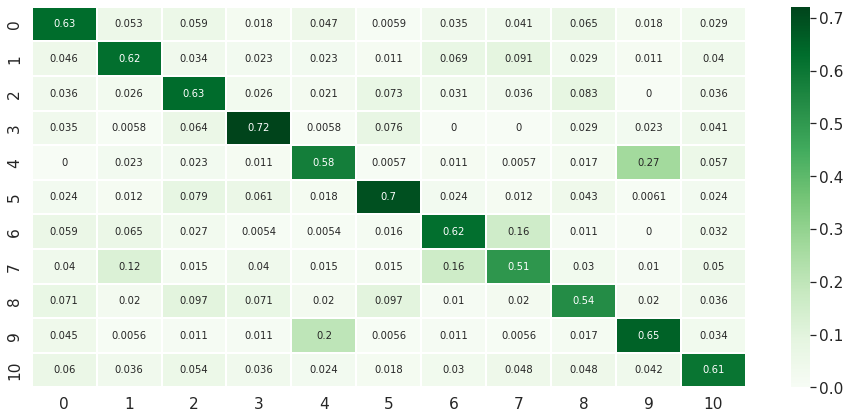

In [14]:
# Import needed packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# If you're working in Jupyter Notebook, include the following so that plots will display:
%matplotlib inline


# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)
"""
# Add labels to the plot
class_names = [i for i in range(len(df.category.unique()))]
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()
"""

## Evaluation functions

In [19]:
def print_metrics(y_test, y_pred):
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    # micro : Calculate metrics globally by counting the total true positives, false negatives and false positives.
    # macro : faire le calcul étiquette par étiquette, puis faire la moyenne
    labels_list=['ARA','CHI','FRE','GER','HIN','ITA','JPN','KOR','SPA','TEL','TUR']
    average_param = "macro"
    print("\nAccuracy ", accuracy_score(y_test, y_pred))

    print("\n- Precision -", average_param)
    tmp = "\n"+str(list(zip(labels_list, precision_score(y_test, y_pred, average=None, zero_division=1))))
    print("precision by language :", tmp.replace("),",")\n").replace("[",'').replace("]",''))
    print("\nprecision score ", precision_score(y_test, y_pred, average=average_param, zero_division=1))

    print("\n- Recall -", average_param)
    tmp = "\n"+str(list(zip(labels_list, recall_score(y_test, y_pred, average=None, zero_division=1))))
    print("recall by language ", tmp.replace("),",")\n").replace("[",'').replace("]",''))
    print("\nrecall score ",   recall_score(y_test, y_pred, average=average_param, zero_division=1))
    tmp = "\n"+str(list(zip(labels_list, f1_score(y_test, y_pred, average=None, zero_division=1))))
    
    print("\n- F1 -", average_param)
    print("f1 by language ", tmp.replace("),",")\n").replace("[",'').replace("]",''))
    print("\nf1 score ", f1_score(y_test, y_pred, average=average_param, zero_division=1))
    
#print_metrics(y_test, y_pred)

In [20]:
def draw_confusion_matrix(y_test, y_pred, langs_label=['ARA',\
 'CHI',
 'FRE',
 'GER',
 'HIN',
 'ITA',
 'JPN',
 'KOR',
 'SPA',
 'TEL',
 'TUR'], 
                          class_labels_dict=class_labels_dict):
    import plotly.express as px
    lang2num = {v: k for k, v in class_labels_dict.items()}
    lang_list =  [ lang2num[k] for k in langs_label] 
    data = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=lang_list)
    fig = px.imshow(data,
                    labels=dict(x="Languages y_test", y="Languages y_pred", color="confusion"),
                    x=langs_label,
                    y=langs_label,
                    text_auto=True,
                    aspect="auto")
    fig.update_xaxes(side="top")
    fig.show()


In [21]:
def evaluation(y_test, y_pred, labels_list=['ARA',\
 'CHI',
 'FRE',
 'GER',
 'HIN',
 'ITA',
 'JPN',
 'KOR',
 'SPA',
 'TEL',
 'TUR'],
               class_labels_dict:dict=class_labels_dict, 
               exclude:list=[""]):
    print("\n-- EVALUATION --\n")
    draw_confusion_matrix(y_test, y_pred, langs_label=labels_list, class_labels_dict=class_labels_dict)

    print_metrics(y_test, y_pred)
   

In [22]:
evaluation(y_test, y_pred)


-- EVALUATION --




Accuracy  0.6161616161616161

- Precision - macro
precision by language : 
('ARA', 0.5846994535519126)
 ('CHI', 0.615819209039548)
 ('FRE', 0.5980392156862745)
 ('GER', 0.6927374301675978)
 ('HIN', 0.6)
 ('ITA', 0.6551724137931034)
 ('JPN', 0.6203208556149733)
 ('KOR', 0.576271186440678)
 ('SPA', 0.6140350877192983)
 ('TEL', 0.6256684491978609)
 ('TUR', 0.5964912280701754)

precision score  0.6162958662983111

- Recall - macro
recall by language  
('ARA', 0.6294117647058823)
 ('CHI', 0.6228571428571429)
 ('FRE', 0.6321243523316062)
 ('GER', 0.7209302325581395)
 ('HIN', 0.5795454545454546)
 ('ITA', 0.6951219512195121)
 ('JPN', 0.6236559139784946)
 ('KOR', 0.5074626865671642)
 ('SPA', 0.5357142857142857)
 ('TEL', 0.6536312849162011)
 ('TUR', 0.6071428571428571)

recall score  0.6188725387760672

- F1 - macro
f1 by language  
('ARA', 0.6062322946175637)
 ('CHI', 0.6193181818181819)
 ('FRE', 0.614609571788413)
 ('GER', 0.7065527065527065)
 ('HIN', 0.5895953757225433)
 ('ITA', 0.6745562130

## TF-IDF vs Bag of Words

In [23]:
# tf-idf transform
tf_X_train = tf.transform(X_train)
tf_X_test = tf.transform(X_test)

In [24]:
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression()
logisticRegr.fit(tf_X_train, train_category)
logisticRegr_predict = logisticRegr.predict(tf_X_test)
print(len(logisticRegr_predict))

1980


/home/clinton/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [27]:
print("Score logistic regression with TF-IDF whithout cleaning text :", logisticRegr.score(tf_X_test, test_category))

Score logistic regression with TF-IDF whithout cleaning text : 0.6464646464646465


In [28]:
evaluation(test_category, logisticRegr_predict)


-- EVALUATION --




Accuracy  0.6464646464646465

- Precision - macro
precision by language : 
('ARA', 0.6075949367088608)
 ('CHI', 0.6363636363636364)
 ('FRE', 0.7150837988826816)
 ('GER', 0.7105263157894737)
 ('HIN', 0.5671641791044776)
 ('ITA', 0.6455026455026455)
 ('JPN', 0.6910112359550562)
 ('KOR', 0.6540880503144654)
 ('SPA', 0.675)
 ('TEL', 0.6559139784946236)
 ('TUR', 0.5647668393782384)

precision score  0.6475468742267417

- Recall - macro
recall by language  
('ARA', 0.5647058823529412)
 ('CHI', 0.68)
 ('FRE', 0.6632124352331606)
 ('GER', 0.7848837209302325)
 ('HIN', 0.6477272727272727)
 ('ITA', 0.7439024390243902)
 ('JPN', 0.6612903225806451)
 ('KOR', 0.5174129353233831)
 ('SPA', 0.5510204081632653)
 ('TEL', 0.6815642458100558)
 ('TUR', 0.6488095238095238)

recall score  0.6495026532686246

- F1 - macro
f1 by language  
('ARA', 0.5853658536585367)
 ('CHI', 0.6574585635359116)
 ('FRE', 0.6881720430107526)
 ('GER', 0.7458563535911603)
 ('HIN', 0.6047745358090185)
 ('ITA', 0.6912181303116147)
 

## Cleaning text

In [29]:
# cleaning test
from nltk.corpus import stopwords

stopwords = set(stopwords.words('english'))

def clean_text(text):
    """
    Clean the input text 
    """
    cleaned_text = text.lower()
    cleaned_text = re.sub('[^a-zA-Z0-9$\s]', '', cleaned_text)
    cleaned_text = cleaned_text.split()
    cleaned_text = [word for word in cleaned_text if word not in stopwords and len(word) > 1]
 
    return " ".join(cleaned_text)


def create_stop_word_dict(stopwords):
    return {k:0 for k in stopwords}
# create lang stop words dict 
def create_lswd(lang):
    return {k:create_stop_word_dict(stopwords) for k in lang}


lswd = create_lswd(df['category'].unique())


def row_sw(row, lswd, stopword):
    _,text,lang = row
    text = text.lower().split()
    for word in  text:
        if word in stopword:
            lswd[lang][word] = lswd[lang][word] + 1


for w in df.itertuples():
    row_sw(w,lswd,stopwords)


In [30]:
lswd['GER']

{"you'd": 0,
 'which': 1029,
 'when': 785,
 'as': 1934,
 'mightn': 0,
 'were': 217,
 'the': 14297,
 'off': 35,
 'why': 401,
 "aren't": 0,
 'ma': 1,
 'same': 287,
 'i': 3899,
 'been': 218,
 'do': 2178,
 'against': 53,
 "it's": 0,
 'being': 301,
 "she's": 0,
 'll': 7,
 'have': 3086,
 'each': 128,
 'no': 457,
 'it': 3961,
 'those': 202,
 "you'll": 0,
 'not': 3176,
 'very': 835,
 'mustn': 0,
 'their': 2115,
 'weren': 0,
 'he': 758,
 'again': 107,
 'having': 243,
 'who': 852,
 'was': 438,
 'didn': 0,
 'ourselves': 8,
 'through': 100,
 'that': 5291,
 'can': 1830,
 'other': 1036,
 "weren't": 0,
 'because': 1146,
 've': 0,
 'isn': 4,
 'from': 715,
 'doesn': 5,
 "you're": 0,
 'you': 3514,
 'only': 926,
 't': 31,
 'than': 1303,
 'him': 99,
 'herself': 10,
 'she': 186,
 'of': 7348,
 'doing': 292,
 'an': 1174,
 'while': 148,
 'our': 424,
 'them': 778,
 "mustn't": 0,
 'below': 5,
 'yourselves': 0,
 'aren': 2,
 'her': 140,
 'few': 134,
 'own': 376,
 'further': 75,
 'hasn': 0,
 'y': 1,
 'both': 193,


In [31]:
a = list(lswd['GER'].items())
a.sort(key=lambda x: x[1], reverse=True)

a[:10]

[('the', 14297),
 ('to', 11735),
 ('a', 7855),
 ('of', 7348),
 ('in', 7242),
 ('and', 7231),
 ('is', 5874),
 ('that', 5291),
 ('it', 3961),
 ('i', 3899)]

GER


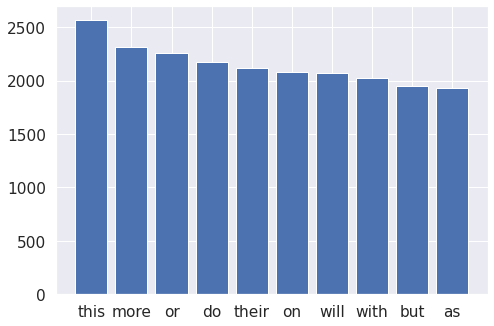

TUR


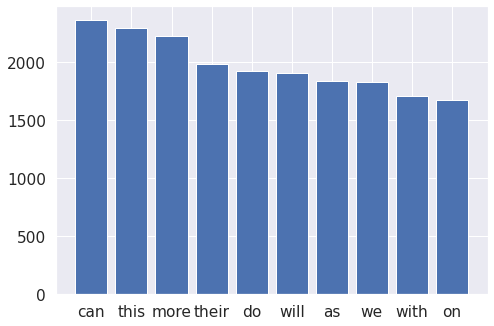

CHI


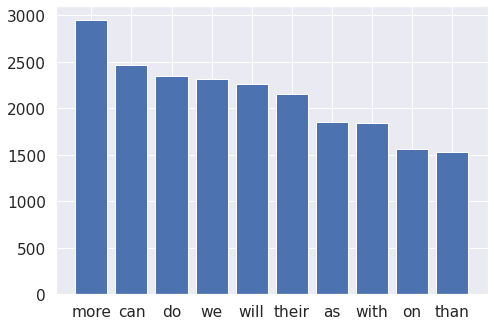

TEL


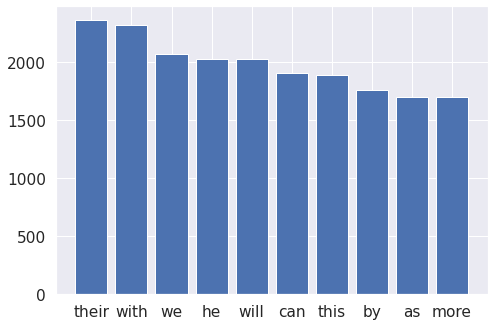

ARA


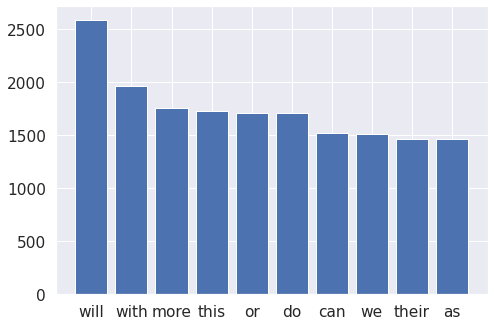

SPA


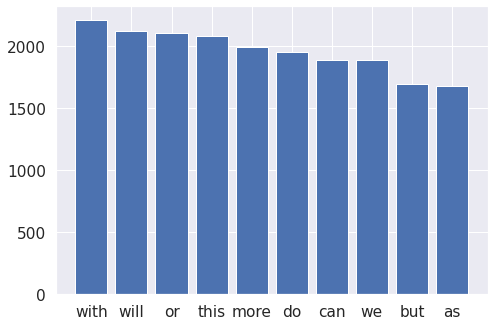

HIN


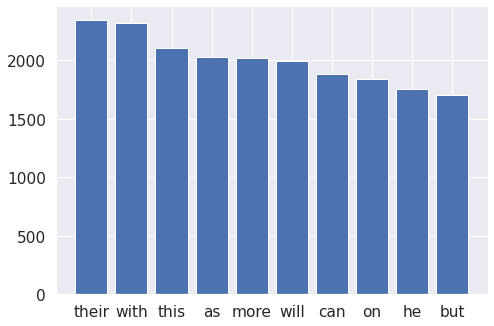

JPN


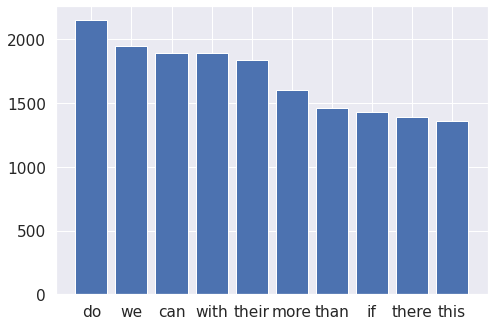

KOR


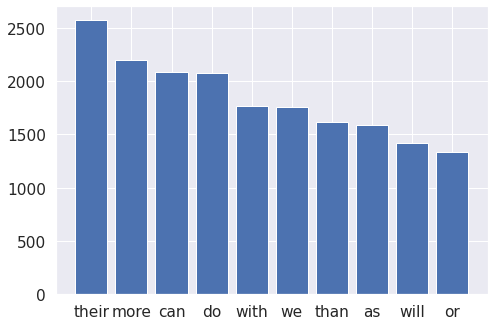

FRE


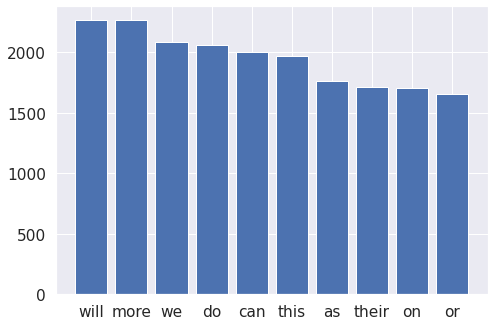

ITA


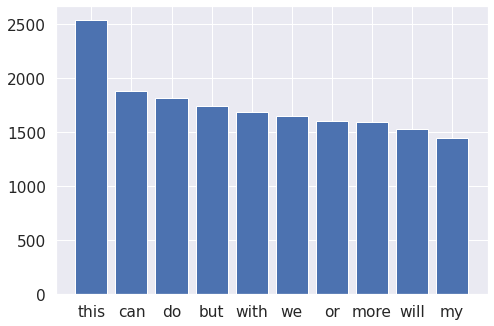

In [49]:
def draw_sw_bar(lswd):
    N = 10
    import matplotlib.pyplot as plt
    for key in lswd.keys():
        a = list(lswd[key].items())
        a.sort(key=lambda x: x[1], reverse=True)
        a = a[:N]
        fig = plt.figure()
        ax = fig.add_axes([0,0,1,1])

        langs = list(map( lambda x:x[0],a))
        students = list(map(lambda x:x[1],a))
        ax.bar(langs,students)
        print(key)
        plt.show()

    
draw_sw_bar(lswd)
# les mots les plus fréquants pour chaque langue

GER


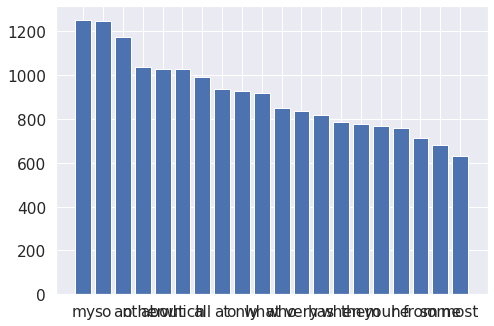

TUR


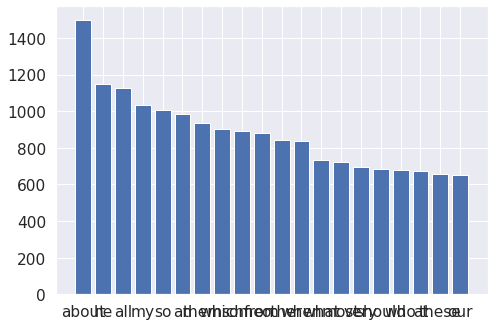

CHI


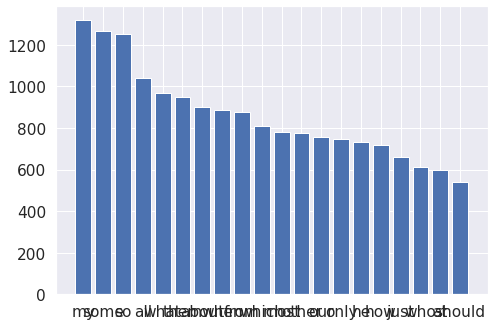

TEL


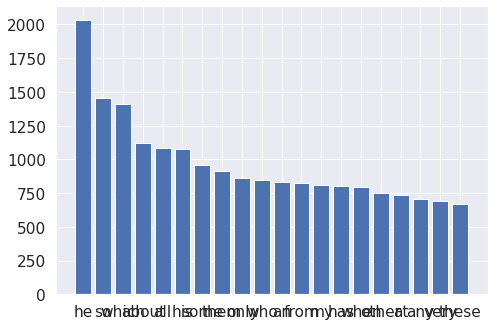

ARA


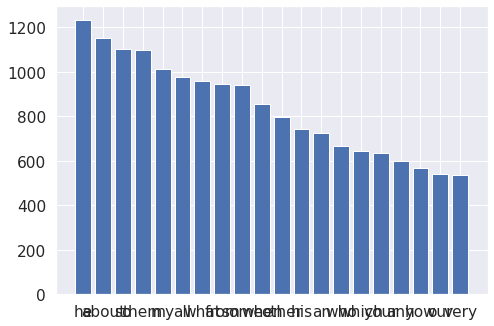

SPA


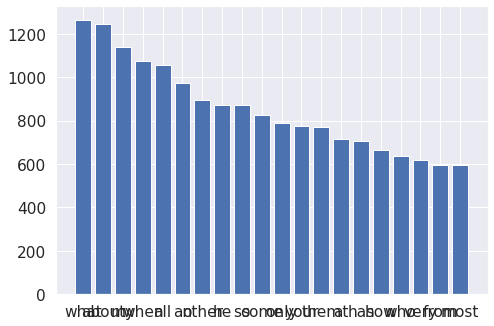

HIN


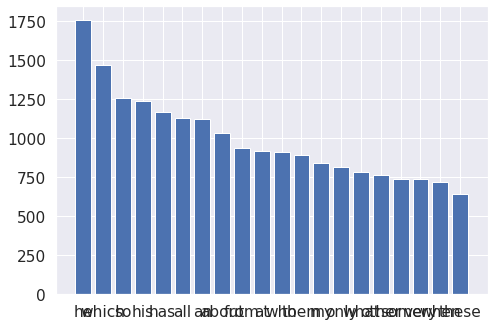

JPN


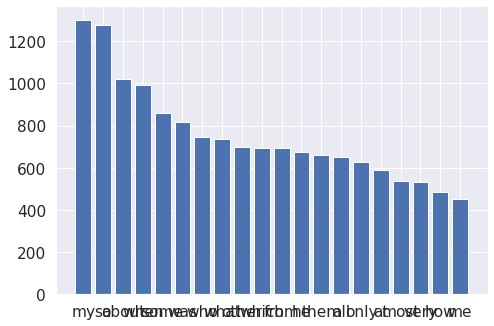

KOR


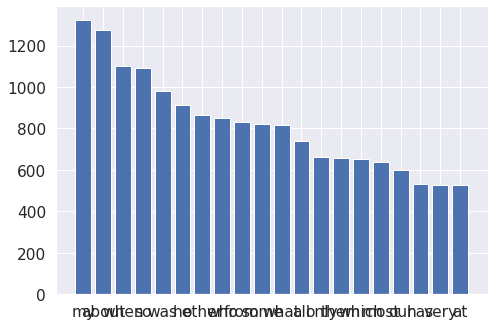

FRE


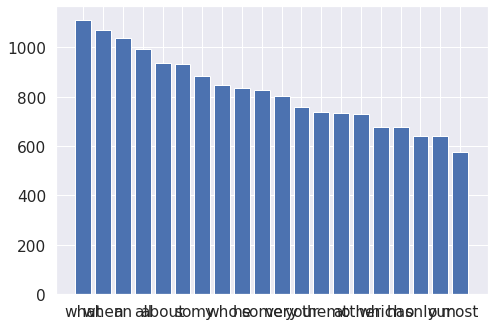

ITA


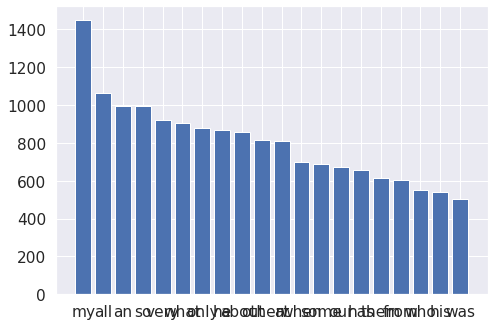

In [65]:
N = 20
def get_commun_stop_word(lswd:dict, nw:int = N, nbr_lang_using_word_after_filter:int = 7):
    """
    Args :
        lswd : language stop words dict
        nw : les N premiers stop words les plus fréquents pour chaque langue
    retourne les stop words qui apparaissent dans nbr_lang_using_word_after_filter après le filtre des nw premiers
    """
    import matplotlib.pyplot as plt
    word_commun = {}
    for key in lswd.keys():
        a = list(lswd[key].items())
        a.sort(key=lambda x: x[1], reverse=True)
        a = a[:nw]
        for item in a:
            if word_commun.get(item[0]) != None:
                word_commun[item[0]] += 1
            else:
                word_commun[item[0]] = 1
    
    return set(map(lambda x:x[0],    filter(lambda x: x[1] > nbr_lang_using_word_after_filter, word_commun.items()) ) )
    


def draw_sw_bar_filter(lswd: dict, nw:int = N):
    """
    Args :
        lswd : language stop words dict
        nw : les N premiers stop words les plus fréquents pour chaque langue
    filtre les N stop words les plus communs
    """
    word_to_remove=get_commun_stop_word(lswd)
    
    for key in lswd.keys():
        for k in word_to_remove:
            if lswd[key].get(k) != None:
                lswd[key].pop(k)
        a = list(lswd[key].items())
        a.sort(key=lambda x: x[1], reverse=True)
        a = a[:nw]
        fig = plt.figure()
        ax = fig.add_axes([0,0,1,1])

        langs = list(map( lambda x:x[0],a))
        students = list(map(lambda x:x[1],a))
        ax.bar(langs,students)
        print(key)
        plt.show()


draw_sw_bar_filter(lswd)

## Remarques
La fréquence et la diversité d'utilisation des stop-words varie selon les langues maternelles.
Les N mots les plus fréquents communs à toutes les langues ne sont pas pris en compte, afin de garder uniquement des stop-words qui permettent de refléter des spécificités de chaque langue.

Nous avons pour chaque langue maternelle, une liste de stop-words spécifiques dans l'ordre de fréquence.

In [66]:
def clean_text_(text, stopwords):
    """
    Clean the input text 
    """
   
    cleaned_text = text.lower()
    cleaned_text = re.sub('[^a-zA-Z0-9$\s]', '', cleaned_text)
    cleaned_text = cleaned_text.split()
    cleaned_text = [word for word in cleaned_text if word.lower() not in stopwords and len(word.lower())>1 ]

    return " ".join(cleaned_text)

new_sw = get_commun_stop_word(lswd)
print(new_sw)
df['cleaned_text_filtered_sw'] = df['text'].apply(lambda x: clean_text_(x,new_sw))

{'at', 'an', 'what', 'which', 'when', 'very', 'them', 'my', 'he', 'other', 'some', 'so', 'about', 'all', 'from', 'who', 'only'}


In [67]:
df.head(10)

,text,category,cleaned_text,cleaned_text_filtered_sw,cleaned_text_all_sw
0,IThe importance and popularity of travelling i...,GER,ithe importance and popularity of travelling i...,ithe importance and popularity of travelling i...,ithe importance popularity travelling still ra...
1,"It is an important decision , how to plan your...",TUR,it is an important decision how to plan your s...,it is important decision how to plan your syll...,important decision plan syllabus students pref...
2,Some people believe that young people can enjo...,CHI,some people believe that young people enjoy li...,people believe that young people can enjoy lif...,people believe young people enjoy life older p...
3,Travelling is usually considered as good recre...,TEL,travelling is usually considered good recreati...,travelling is usually considered as good recre...,travelling usually considered good recreation ...
4,i agree that . Life is a person live period of...,ARA,agree that life is person live period of time ...,agree that life is person live period of time ...,agree life person live period time people beli...
5,"In my opinion , travel in group with a tour gu...",SPA,in my opinion travel in group tour guide is no...,in opinion travel in group with tour guide is ...,opinion travel group tour guide good way trave...
6,I thing the statement '' Young people nowadays...,GER,thing the statement young people nowadays not ...,thing the statement young people nowadays do n...,thing statement young people nowadays give eno...
7,Whether or not young people enjoy life more th...,GER,whether not young people enjoy life than older...,whether or not young people enjoy life more th...,whether young people enjoy life older people i...
8,"In the era of science and technology , the peo...",HIN,in the era of science and technology the peopl...,in the era of science and technology the peopl...,era science technology people generally pay at...
9,I agree with this statement . I think that in ...,JPN,agree statement think that in twenty years the...,agree with this statement think that in twenty...,agree statement think twenty years fewer cars ...


In [68]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = df['cleaned_text_filtered_sw'].values.tolist()
y = df['category'].values.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
logisticRegr = LogisticRegression()
tf_X_train = tf.transform(X_train)
tf_X_test = tf.transform(X_test)
logisticRegr.fit(tf_X_train, train_category)
logisticRegr_predict = logisticRegr.predict(tf_X_test)
print(len(logisticRegr_predict))

1980


/home/clinton/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [69]:
print("Score logistic regression with TF-IDF after cleaning frequent stop words :", logisticRegr.score(tf_X_test, test_category))
evaluation(test_category, logisticRegr_predict)


Score logistic regression with TF-IDF after cleaning frequent stop words : 0.6368686868686869

-- EVALUATION --




Accuracy  0.6368686868686869

- Precision - macro
precision by language : 
('ARA', 0.6174496644295302)
 ('CHI', 0.6310160427807486)
 ('FRE', 0.6910112359550562)
 ('GER', 0.7243243243243244)
 ('HIN', 0.5671641791044776)
 ('ITA', 0.6020408163265306)
 ('JPN', 0.6795580110497238)
 ('KOR', 0.6455696202531646)
 ('SPA', 0.6496815286624203)
 ('TEL', 0.6443298969072165)
 ('TUR', 0.5670103092783505)

precision score  0.6381050571883221

- Recall - macro
recall by language  
('ARA', 0.5411764705882353)
 ('CHI', 0.6742857142857143)
 ('FRE', 0.6373056994818653)
 ('GER', 0.7790697674418605)
 ('HIN', 0.6477272727272727)
 ('ITA', 0.7195121951219512)
 ('JPN', 0.6612903225806451)
 ('KOR', 0.5074626865671642)
 ('SPA', 0.5204081632653061)
 ('TEL', 0.6983240223463687)
 ('TUR', 0.6547619047619048)

recall score  0.6401203835607535

- F1 - macro
f1 by language  
('ARA', 0.5768025078369906)
 ('CHI', 0.6519337016574586)
 ('FRE', 0.6630727762803235)
 ('GER', 0.7507002801120449)
 ('HIN', 0.6047745358090185)
 ('

## Remarque (avec / sans stop words fréquents)
La suppression de quelques stop words a engendré une perte légère des performances globales : 0.646 -> 0.636

En effet, on remarque une perte du rappel sur la majorité des langues.
Excepté TEL et TUR où le gain est négligeable

### Analyse des stops word :

In [62]:
import nltk
from nltk.corpus import stopwords

stops = set(stopwords.words('english'))
print("number of all stop words to be deleted", len(stops))

df['cleaned_text_all_sw'] = df['text'].apply(lambda x: clean_text_(x, stops))
df.head(10)

number of all stop words to be deleted 179


,text,category,cleaned_text,cleaned_text_filtered_sw,cleaned_text_all_sw
0,IThe importance and popularity of travelling i...,GER,ithe importance and popularity of travelling i...,ithe importance and popularity of travelling i...,ithe importance popularity travelling still ra...
1,"It is an important decision , how to plan your...",TUR,it is an important decision how to plan your s...,it is an important decision how to plan your s...,important decision plan syllabus students pref...
2,Some people believe that young people can enjo...,CHI,some people believe that young people enjoy li...,some people believe that young people enjoy li...,people believe young people enjoy life older p...
3,Travelling is usually considered as good recre...,TEL,travelling is usually considered good recreati...,travelling is usually considered good recreati...,travelling usually considered good recreation ...
4,i agree that . Life is a person live period of...,ARA,agree that life is person live period of time ...,agree that life is person live period of time ...,agree life person live period time people beli...
5,"In my opinion , travel in group with a tour gu...",SPA,in my opinion travel in group tour guide is no...,in my opinion travel in group tour guide is no...,opinion travel group tour guide good way trave...
6,I thing the statement '' Young people nowadays...,GER,thing the statement young people nowadays not ...,thing the statement young people nowadays not ...,thing statement young people nowadays give eno...
7,Whether or not young people enjoy life more th...,GER,whether not young people enjoy life than older...,whether not young people enjoy life than older...,whether young people enjoy life older people i...
8,"In the era of science and technology , the peo...",HIN,in the era of science and technology the peopl...,in the era of science and technology the peopl...,era science technology people generally pay at...
9,I agree with this statement . I think that in ...,JPN,agree statement think that in twenty years the...,agree statement think that in twenty years the...,agree statement think twenty years fewer cars ...


In [64]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = df['cleaned_text_all_sw'].values.tolist()
y = df['category'].values.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
logisticRegr = LogisticRegression()
tf_X_train = tf.transform(X_train)
tf_X_test = tf.transform(X_test)
logisticRegr.fit(tf_X_train, train_category)
logisticRegr_predict = logisticRegr.predict(tf_X_test)
print(len(logisticRegr_predict))

print("Score logistic regression with TF-IDF after cleaning all stop words :", logisticRegr.score(tf_X_test, test_category))
evaluation(test_category, logisticRegr_predict)

1980
Score logistic regression with TF-IDF after cleaning all stop words : 0.6388888888888888

-- EVALUATION --



/home/clinton/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression




Accuracy  0.6388888888888888

- Precision - macro
precision by language : 
('ARA', 0.6283783783783784)
 ('CHI', 0.6270270270270271)
 ('FRE', 0.6971428571428572)
 ('GER', 0.7225130890052356)
 ('HIN', 0.5588235294117647)
 ('ITA', 0.5959595959595959)
 ('JPN', 0.7005649717514124)
 ('KOR', 0.6335403726708074)
 ('SPA', 0.6582278481012658)
 ('TEL', 0.6479591836734694)
 ('TUR', 0.5721925133689839)

precision score  0.6402117605900725

- Recall - macro
recall by language  
('ARA', 0.5470588235294118)
 ('CHI', 0.6628571428571428)
 ('FRE', 0.6321243523316062)
 ('GER', 0.8023255813953488)
 ('HIN', 0.6477272727272727)
 ('ITA', 0.7195121951219512)
 ('JPN', 0.6666666666666666)
 ('KOR', 0.5074626865671642)
 ('SPA', 0.5306122448979592)
 ('TEL', 0.7094972067039106)
 ('TUR', 0.6369047619047619)

recall score  0.6420680849730178

- F1 - macro
f1 by language  
('ARA', 0.5849056603773586)
 ('CHI', 0.6444444444444445)
 ('FRE', 0.6630434782608696)
 ('GER', 0.7603305785123967)
 ('HIN', 0.6)
 ('ITA', 0.6519337

## Remarque (suppression de tous les stop words)
La suppression de tous les stop words réduit légèrement les performances d'un point.
On remarque également une perte du rappel sur la majorité des langues. Excepté GER, JAP, TUR où le gain est négligeable

# Impact du stemming

In [73]:
def stem_text(text):
    from nltk.stem import PorterStemmer
    stemmer = PorterStemmer()
    
    tokens = text.split()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    stemmed_text = " ".join(stemmed_tokens)
    return stemmed_text

df['text_stem'] = df['text'].apply(stem_text)
df[["text", "text_stem"]].head()

,text,text_stem
0,IThe importance and popularity of travelling i...,ith import and popular of travel is still rais...
1,"It is an important decision , how to plan your...","it is an import decis , how to plan your sylla..."
2,Some people believe that young people can enjo...,some peopl believ that young peopl can enjoy l...
3,Travelling is usually considered as good recre...,travel is usual consid as good recreat by mani...
4,i agree that . Life is a person live period of...,i agre that . life is a person live period of ...


In [74]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = df['text_stem'].values.tolist()
y = df['category'].values.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
logisticRegr = LogisticRegression()
tf_X_train = tf.transform(X_train)
tf_X_test = tf.transform(X_test)
logisticRegr.fit(tf_X_train, train_category)
logisticRegr_predict = logisticRegr.predict(tf_X_test)

print("Score logistic regression with TF-IDF after Stemming text :", logisticRegr.score(tf_X_test, test_category))
evaluation(test_category, logisticRegr_predict)

Score logistic regression with TF-IDF after Stemming text : 0.48838383838383836

-- EVALUATION --



/home/clinton/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression




Accuracy  0.48838383838383836

- Precision - macro
precision by language : 
('ARA', 0.5135135135135135)
 ('CHI', 0.4512820512820513)
 ('FRE', 0.6052631578947368)
 ('GER', 0.5353535353535354)
 ('HIN', 0.4482758620689655)
 ('ITA', 0.48186528497409326)
 ('JPN', 0.5491329479768786)
 ('KOR', 0.47465437788018433)
 ('SPA', 0.4716981132075472)
 ('TEL', 0.510989010989011)
 ('TUR', 0.34375)

precision score  0.4896161686491379

- Recall - macro
recall by language  
('ARA', 0.4470588235294118)
 ('CHI', 0.5028571428571429)
 ('FRE', 0.47668393782383417)
 ('GER', 0.6162790697674418)
 ('HIN', 0.5170454545454546)
 ('ITA', 0.5670731707317073)
 ('JPN', 0.510752688172043)
 ('KOR', 0.5124378109452736)
 ('SPA', 0.3826530612244898)
 ('TEL', 0.5195530726256983)
 ('TUR', 0.3273809523809524)

recall score  0.4890704713275864

- F1 - macro
f1 by language  
('ARA', 0.4779874213836478)
 ('CHI', 0.4756756756756757)
 ('FRE', 0.5333333333333332)
 ('GER', 0.572972972972973)
 ('HIN', 0.48021108179419525)
 ('ITA', 0.5

## Remarque : impact du Stemming
Le stemming a complétement endommagé le modèle.
En effet, dans notre cas d'usage, on se concentre sur la recherche de singularités, alors que le stemming recherche la généralité.

## Impact de la lemmatization

In [77]:
def lemmatize_text(text):
    from nltk.stem import WordNetLemmatizer
    
    wordnet_lemmatizer = WordNetLemmatizer()
    
    tokens = text.split()
    lemmatized_tokens = [wordnet_lemmatizer.lemmatize(token) for token in tokens]
    lemmatized_text = " ".join(lemmatized_tokens)
    return lemmatized_text

df['text_lemma'] = df['text'].apply(lemmatize_text)
df[["text", "text_lemma"]].head()

,text,text_lemma
0,IThe importance and popularity of travelling i...,IThe importance and popularity of travelling i...
1,"It is an important decision , how to plan your...","It is an important decision , how to plan your..."
2,Some people believe that young people can enjo...,Some people believe that young people can enjo...
3,Travelling is usually considered as good recre...,Travelling is usually considered a good recrea...
4,i agree that . Life is a person live period of...,i agree that . Life is a person live period of...


In [78]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = df['text_lemma'].values.tolist()
y = df['category'].values.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
logisticRegr = LogisticRegression()
tf_X_train = tf.transform(X_train)
tf_X_test = tf.transform(X_test)
logisticRegr.fit(tf_X_train, train_category)
logisticRegr_predict = logisticRegr.predict(tf_X_test)

print("Score logistic regression with TF-IDF after Lemmatization text :", logisticRegr.score(tf_X_test, test_category))
evaluation(test_category, logisticRegr_predict)

Score logistic regression with TF-IDF after Lemmatization text : 0.6106060606060606

-- EVALUATION --



/home/clinton/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression




Accuracy  0.6106060606060606

- Precision - macro
precision by language : 
('ARA', 0.5961538461538461)
 ('CHI', 0.5663265306122449)
 ('FRE', 0.7388535031847133)
 ('GER', 0.6666666666666666)
 ('HIN', 0.5414634146341464)
 ('ITA', 0.6574585635359116)
 ('JPN', 0.6397849462365591)
 ('KOR', 0.573170731707317)
 ('SPA', 0.6375)
 ('TEL', 0.6030150753768844)
 ('TUR', 0.5217391304347826)

precision score  0.6129211280493702

- Recall - macro
recall by language  
('ARA', 0.5470588235294118)
 ('CHI', 0.6342857142857142)
 ('FRE', 0.6010362694300518)
 ('GER', 0.7441860465116279)
 ('HIN', 0.6306818181818182)
 ('ITA', 0.725609756097561)
 ('JPN', 0.6397849462365591)
 ('KOR', 0.46766169154228854)
 ('SPA', 0.5204081632653061)
 ('TEL', 0.6703910614525139)
 ('TUR', 0.5714285714285714)

recall score  0.6138666238146748

- F1 - macro
f1 by language  
('ARA', 0.5705521472392638)
 ('CHI', 0.5983827493261454)
 ('FRE', 0.6628571428571428)
 ('GER', 0.7032967032967034)
 ('HIN', 0.5826771653543307)
 ('ITA', 0.68985

## Remarque : impact de la lemmatization
La lemmatization a négativement impacté les performances du modèle. En effet, même problème avec le stemming, dans notre cas d'usage on se concentre sur la recherche de singularités, alors que la lemmatization recherche la généralité. La lemmatization reste mieux que le stemming car elle ne découpe pas les mots contrairement au stemming.

## Fréquences de la ponctuation dans chaque langue

/tmp/ipykernel_14776/588828588.py:3: ParserWarning:

Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.



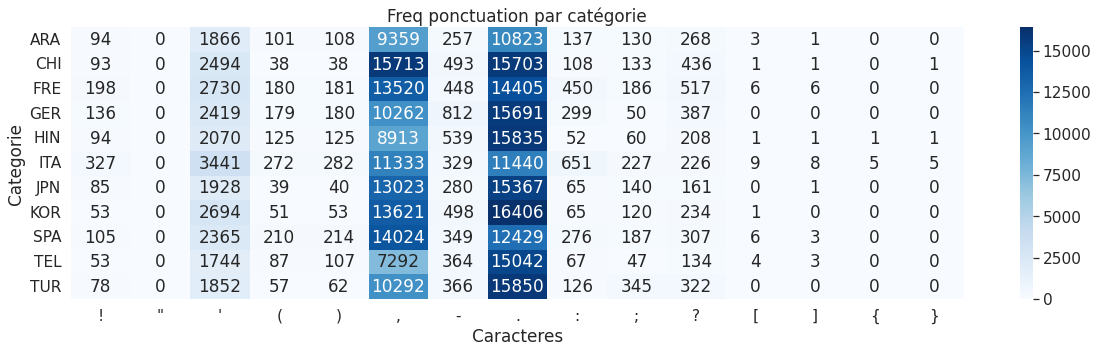

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns

df = load_data(path=r'./train.txt')

# grouper puis concatener les textes de chaque catégorie
df_punct = df.groupby(['category'])['text'].apply(''.join).reset_index()
punctuation = ['.', ',', ';', ':', '?', '!', '-', '(', ')', '[', ']', '{', '}', '\'', '\"']
for p in punctuation:
    df_punct[p] = df_punct['text'].apply(lambda x: x.count(p))
    
plt.figure(figsize=(20, 5))
heatmap_data = pd.pivot_table(df_punct, values=punctuation, index=['category'], aggfunc=np.sum)
sns.heatmap(heatmap_data, cmap='Blues', annot=True, fmt='.0f')
plt.title("Freq ponctuation par catégorie")
plt.xlabel("Caracteres")
plt.ylabel("Categorie")
plt.show()

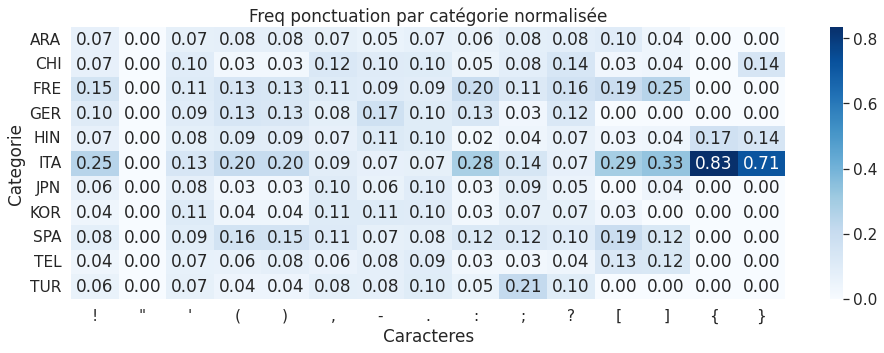

In [101]:
# normalisation par colonne (par caractère)
for p in punctuation:
    df_punct[p] = df_punct[p] / df_punct[p].sum()

plt.figure(figsize=(16, 5))
heatmap_data = pd.pivot_table(df_punct, values=punctuation, index=['category'], aggfunc=np.sum)
sns.heatmap(heatmap_data, cmap='Blues', annot=True, fmt='.2f')
plt.title("Freq ponctuation par catégorie normalisée")
plt.xlabel("Caracteres")
plt.ylabel("Categorie")
plt.show()

## Remarque : fréquences des caractères de ponctuation par langue
On observe quelques caractères spéciaux présents dans une langue spécifique comme l'italien ! Alors que d'autres sont présents partout de façon homogène notamment le point et la virgule.

/tmp/ipykernel_14776/588828588.py:3: ParserWarning:

Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.



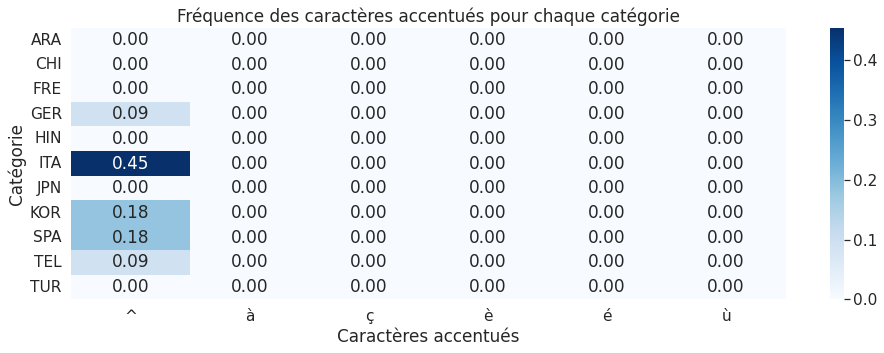

In [110]:
df = load_data(path=r'./train.txt')

df_car = df.groupby(['category'])['text'].apply(''.join).reset_index()
caracteres = ['é', 'è', 'ç', 'à', 'ù', '^']
for c in caracteres:
    df_car[c] = df_car['text'].apply(lambda x: x.count(c))
for c in caracteres:
    df_car[c] = df_car[c] / df_car[c].sum()

plt.figure(figsize=(16, 5))
heatmap_data = pd.pivot_table(df_car, values=caracteres, index=['category'], aggfunc=np.sum)
sns.heatmap(heatmap_data, cmap='Blues', annot=True, fmt='.2f')
plt.title("Fréquence des caractères accentués pour chaque catégorie")
plt.xlabel("Caractères accentués")
plt.ylabel("Catégorie")
plt.show()

## Longueur moyenne des textes par catégorie

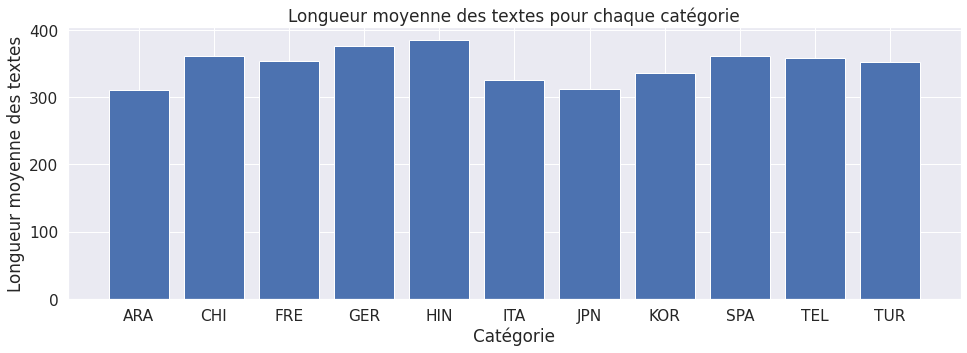

In [114]:
import pandas as pd
import matplotlib.pyplot as plt

df['text_length'] = df['text'].apply(lambda x: len(x.split()))
mean_length = df.groupby('category')['text_length'].mean()

plt.figure(figsize=(16, 5))
plt.bar(mean_length.index, mean_length.values)
plt.title("Longueur moyenne des textes pour chaque catégorie")
plt.xlabel("Catégorie")
plt.ylabel("Longueur moyenne des textes")
plt.show()


In [119]:
# boxplot avec plotly
import plotly.express as px

df['text_length'] = df['text'].apply(lambda x: len(x.split()))
mean_length = df.groupby('category')['text_length'].mean().reset_index()

fig = px.box(df, x='category', y='text_length')
fig.update_layout(title="Nombre de mots moyen par catégorie",
                  xaxis_title="Catégorie",
                  yaxis_title="Nombre de mots moyen")
fig.show()

In [121]:
# distribution
fig = px.histogram(df, x="text_length", color="category", nbins=50,
                   marginal="box", title="Distribution du nombre de mots par catégorie")

fig.update_layout(xaxis_title="Nombre de mots", yaxis_title="Fréquence")
fig.show()

## Longueur moyenne des phrases par catégorie

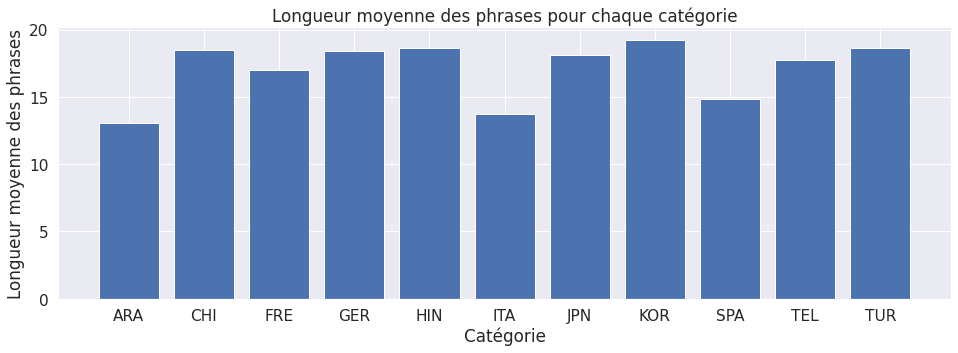

In [115]:
import pandas as pd
import matplotlib.pyplot as plt

df['phrase_length'] = df['text'].apply(lambda x: len(x.split('.'))) # phrase se terminant par un point
df['phrase_length'] = df['phrase_length'].apply(lambda x: x if x > 0 else 1)
mean_length = df.groupby('category')['phrase_length'].mean()

plt.figure(figsize=(16, 5))
plt.bar(mean_length.index, mean_length.values)
plt.title("Longueur moyenne des phrases pour chaque catégorie")
plt.xlabel("Catégorie")
plt.ylabel("Longueur moyenne des phrases")
plt.show()
